In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

import cv2
import PIL

# import ML/DL libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import utils, svm, metrics # used to shuffle data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from tf_explain.core.grad_cam import GradCAM


from keras.preprocessing.image import ImageDataGenerator # used for image augmentation
from tensorflow.keras.applications.inception_v3 import preprocess_input


import tensorflow as tf
# used for building and training a new model
from keras import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16, ResNet50

# import functions from other python files
from code_files.imagePreprocessing import * 

Total number of images:  480


<AxesSubplot:ylabel='count'>

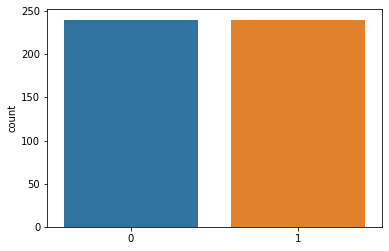

In [2]:
# ********************************
#           IMPORT IMAGES
# ********************************
# import images (and labels) and store in dataframe
# FLAG: set the path to the desired dataset
data_path = 'C:/Users/Rebecca/Documents/Virginia_Tech/Research/database-images/database-images/orig/spiral/'  

trainImgs = pd.DataFrame()
trainArray = []

img_path = []
lbl = []
lblName = []

for group in os.listdir(data_path): # group = healthy or parkinsons
    for img in os.listdir(os.path.join(data_path, group)):
        path = os.path.join(data_path, group, img)
        img_path.append(path) 

        # convert the image and store as a matrix
        drawing = cv2.imread(path)
        drawing = cv2.resize(drawing, (224,224))

        trainArray.append(drawing)

        # store the labels
        if group == 'healthy':
            lbl.append(0)
            lblName.append('healthy')
        else:
            lbl.append(1)
            lblName.append('parkinsons')

trainLbls = lbl
trainImgs['image'] = img_path
trainImgs['label'] = lblName


# shuffle the data
# trainImgs, trainArray, trainLbls = utils.shuffle(trainImgs, trainArray, trainLbls)

# convert labels to categorical for training model
trainLbls_categorical = tf.keras.utils.to_categorical(trainLbls)
# print("Labels of first 5 images: \n", trainLbls_categorical[0:5])

# used in the feature extraction section
numImgs = len(trainLbls)
print("Total number of images: ", numImgs)

sns.countplot(trainLbls)

In [3]:
# ******************************
#         IMPORT MODEL
# ******************************
# import ResNet-50 pretrained model 
model = ResNet50(weights='imagenet', include_top=False,input_shape=(224,224,3)) # setting include_top=False removes the fully connected layers of the model
# model.summary()

# summarize feature map shapes # FLAG: can uncomment for feature visualization
for i in range(len(model.layers)):
    layer=model.layers[i]
    # check for conv layer
    if 'conv' in layer.name:
        print(i, layer.name, layer.output.shape)

1 conv1_pad (None, 230, 230, 3)
2 conv1_conv (None, 112, 112, 64)
3 conv1_bn (None, 112, 112, 64)
4 conv1_relu (None, 112, 112, 64)
7 conv2_block1_1_conv (None, 56, 56, 64)
8 conv2_block1_1_bn (None, 56, 56, 64)
9 conv2_block1_1_relu (None, 56, 56, 64)
10 conv2_block1_2_conv (None, 56, 56, 64)
11 conv2_block1_2_bn (None, 56, 56, 64)
12 conv2_block1_2_relu (None, 56, 56, 64)
13 conv2_block1_0_conv (None, 56, 56, 256)
14 conv2_block1_3_conv (None, 56, 56, 256)
15 conv2_block1_0_bn (None, 56, 56, 256)
16 conv2_block1_3_bn (None, 56, 56, 256)
17 conv2_block1_add (None, 56, 56, 256)
18 conv2_block1_out (None, 56, 56, 256)
19 conv2_block2_1_conv (None, 56, 56, 64)
20 conv2_block2_1_bn (None, 56, 56, 64)
21 conv2_block2_1_relu (None, 56, 56, 64)
22 conv2_block2_2_conv (None, 56, 56, 64)
23 conv2_block2_2_bn (None, 56, 56, 64)
24 conv2_block2_2_relu (None, 56, 56, 64)
25 conv2_block2_3_conv (None, 56, 56, 256)
26 conv2_block2_3_bn (None, 56, 56, 256)
27 conv2_block2_add (None, 56, 56, 256)
28 

In [4]:
# ******************************
#     VISUALIZE FEATURE MAPS
# ******************************
# choose second conv block from each layer to display
blocks = [4, 17]
output_layers = [model.layers[i].output for i in blocks]
# redefine model to output right after each conv layer
vis_model = Model(inputs=model.inputs, outputs=output_layers)

train_feat, test_feat, train_lbls, test_lbls = train_test_split(trainArray, trainLbls, test_size=0.2, random_state=42)

# select images to save visualizations for and put them in an array
# manually choose two healthy and two parkinsons
img2vis = np.array([test_feat[0], test_feat[1]])

# iterate through each image and save the feature maps
for i in range(len(img2vis)):
    img = np.expand_dims(img2vis[i], axis=0)
    img = preprocess_input(img)
    feature_maps = vis_model.predict(img)
    blocknum = 0

    for fmap in feature_maps:
        fmap_size = np.shape(fmap)
        # determine the number of images to plot
        if fmap_size[3]==64:
            rows=8;cols=8
        elif fmap_size[3]==128:
            rows=16; cols=8
        elif fmap_size[3]==256:
            rows=16;cols=16
        else:
            rows=16;cols=32

        itr = 1
        fig, ax = plt.subplots(rows,cols, figsize=(75,75))
        title = 'Image_' + str(i) + 'fmap: ' + str(np.shape(fmap))
        fig.suptitle(title)

        for r in range(rows):
            for c in range(cols):
                ax[r][c].imshow(fmap[0,:,:,itr-1], cmap='gray')
                itr += 1

        plt.tight_layout()
        savename = 'Image_' + str(i) + '_block_' +  str(blocks[blocknum]) + '_vgg16_orig_HT.png'
        print(savename)
        fig.savefig(savename)
        plt.close()
        blocknum += 1

1/1 [==============================] - 0s 277ms/step
Image_0_block_4_vgg16_orig_HT.png
Image_0_block_17_vgg16_orig_HT.png
1/1 [==============================] - 0s 37ms/step
Image_1_block_4_vgg16_orig_HT.png
Image_1_block_17_vgg16_orig_HT.png


In [4]:
# ******************************************************************************************************
# ------------------------------------------------------------------------------------------------------
#                                           CLASSIFICATION  
# ------------------------------------------------------------------------------------------------------
# ******************************************************************************************************

# 1. VGG16 or RestNet50
# 2. SVM
# 3. Naive Bayes
# 4. Random Forest

# .........................
#    FEATURE EXTRACTION
# .........................
# define a function that will extract the features from conv network
def extract_features(imgs, num_imgs):
    datagen = ImageDataGenerator(rescale=1./255) # define to rescale pixels in image
    batch_size = 32
    
    features = np.zeros(shape=(num_imgs, 7,7,2048)) # shape equal to output of convolutional base 
    lbls = np.zeros(shape=(num_imgs,2))

    # preprocess data
    generator = datagen.flow_from_dataframe(imgs, x_col = 'image', y_col='label', target_size=(224,224), class_mode='categorical', batch_size=batch_size)

    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        lbls[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= num_imgs:
            break
    return features, lbls

# extract features for both the trainImgs and testImgs
train_feat, train_lbls = extract_features(trainImgs, numImgs)

Found 480 validated image filenames belonging to 2 classes.
1/1 [==============================] - 4s 4s/step


<AxesSubplot:ylabel='count'>

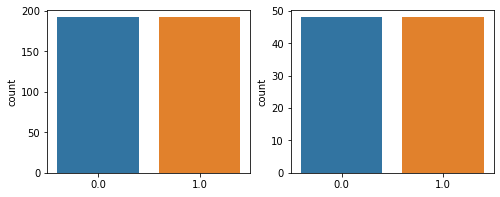

In [5]:
# =============================
#       Train on Fully Connected Layers
# =============================
# split into training and testing data
train_feat, test_feat, train_lbls, test_lbls = train_test_split(train_feat, train_lbls, test_size=0.2, random_state=10, stratify=train_lbls)
trainArray, testArray, _,_ = train_test_split(trainArray, trainLbls, test_size=0.2, random_state=10, stratify=trainLbls)

fig, ax = plt.subplots(1,2, figsize=(8,3))
sns.countplot(train_lbls[:,1], ax=ax[0])
sns.countplot(test_lbls[:,1], ax=ax[1])

In [13]:
# train pre-trained features
# evaluate on VGG16 classifier (using cross validation)
# define a function that will fit the model
def defineModel(size): # size is the dimension of the last layer in the pretrained model
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape=(size,size,2048)))
    # global average pooling is used instead of fully connected layers on top of the feature maps
    # it takes the average of each feature map and the resulting layer is fed directly into the softmax layer
    model.add(Dense(2, activation='softmax'))
    # model.summary()

    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)  # use the Adam optimizer and set an effective learning rate 
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# train the model using cross validation
# will start with k-fold cross validation, taking 80% as training each fold

def fit_and_evaluate(train_feat, train_lbls, val_feat, val_lbls, epochs):
    model = None
    model = defineModel(7) # FLAG: need to set the size based on the last layer
    trained_model = model.fit(train_feat, train_lbls, batch_size=32, epochs=epochs, validation_data=(val_feat, val_lbls), callbacks=model_chkpt, verbose=0)

    # testScore = model.evaluate(test_feat, test_lbls)
    return trained_model

def importModel(filename, testAug, testAugLabel):
    modelPath = filename
    testModel = tf.keras.models.load_model(modelPath)

    loss, acc = testModel.evaluate(np.array(testAug), testAugLabel, verbose=0)
    print("Loss: ", loss, "| Accuracy: ", acc)

    # classification report
    pred = testModel.predict(np.array(testAug))
    pred = np.argmax(pred, axis=1)
    label_pred = np.argmax(testAugLabel, axis=1)
    # print(classification_report(label_pred, pred))

    # confusion matrix
    cfm = confusion_matrix(label_pred, pred)
    # print(cfm)

    tpr = cfm[0][0] / (cfm[0][0] + cfm[1][0])
    tnr = cfm[1][1] / (cfm[1][1] + cfm[0][1])

    return acc, tpr, tnr, cfm

# train with k-fold validation
model_history = []
epochs = 250

num_val_samples = int(np.ceil(len(trainArray) * 0.20))
k = int(np.floor(len(trainArray) / num_val_samples))

fcl_acc = []
fcl_tpr = []
fcl_tnr = []
fcl_cfm = []

for i in range(25):
    print('Random State: ', i+1)
    rs = np.linspace(1, 25, 25).astype(np.int)

    # define model checkpoint callback
    ckpt_name = '20221219_folador_' + str(i+1)+ '.h5'
    model_chkpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, verbose=0, save_best_only=True)

    x_train, x_test, y_train, y_test = train_test_split(train_feat, train_lbls, test_size=0.2, random_state=rs[i], stratify=train_lbls)

    for j in range(k):
        print("Training on fold K = ", j+1, end='\r')
        startPt = j * num_val_samples
        endPt   = (j+1) * num_val_samples

        if endPt > len(x_train):
            endPt = len(x_train)

        val_x = x_train[startPt:endPt]
        val_y = y_train[startPt:endPt]
        train_x = np.delete(x_train, np.linspace(startPt, endPt-1, num_val_samples).astype(np.int), axis=0)
        train_y = np.delete(y_train, np.linspace(startPt, endPt-1, num_val_samples).astype(np.int), axis=0)

        model_history.append(fit_and_evaluate(train_x, train_y, val_x, val_y, epochs=epochs))
        # print(model_history)


    temp_acc, temp_tpr, temp_tnr, temp_cfm = importModel(ckpt_name, x_test, y_test)

    fcl_acc.append(temp_acc)
    fcl_tpr.append(temp_tpr)
    fcl_tnr.append(temp_tnr)
    fcl_cfm.append(temp_cfm)

print("Average accuracy: ", np.mean(fcl_acc))
print("Standard deviation: ", np.std(fcl_acc))
print("Average TNR: ", np.mean(fcl_tnr))
print("Average TPR: ", np.mean(fcl_tpr))

    

Random State:  1
Loss:  0.5724338293075562 | Accuracy:  0.6233766078948975
3/3 [==============================] - 0s 4ms/step
Random State:  2
Loss:  0.5165125727653503 | Accuracy:  0.7402597665786743
3/3 [==============================] - 0s 3ms/step
Random State:  3
Loss:  0.48370540142059326 | Accuracy:  0.8181818127632141
3/3 [==============================] - 0s 3ms/step
Random State:  4
Loss:  0.5244485139846802 | Accuracy:  0.7532467246055603
3/3 [==============================] - 0s 3ms/step
Random State:  5
Loss:  0.6034515500068665 | Accuracy:  0.6623376607894897
3/3 [==============================] - 0s 3ms/step
Random State:  6
Loss:  0.553978681564331 | Accuracy:  0.7142857313156128
3/3 [==============================] - 0s 3ms/step
Random State:  7
Loss:  0.5052992701530457 | Accuracy:  0.7532467246055603
3/3 [==============================] - 0s 3ms/step
Random State:  8
Loss:  0.5432925820350647 | Accuracy:  0.7662337422370911
3/3 [==============================] - 0s 3

In [14]:
print(fcl_cfm)

[array([[29, 10],
       [19, 19]], dtype=int64), array([[29,  9],
       [11, 28]], dtype=int64), array([[28, 10],
       [ 4, 35]], dtype=int64), array([[32,  6],
       [13, 26]], dtype=int64), array([[33,  6],
       [20, 18]], dtype=int64), array([[27, 11],
       [11, 28]], dtype=int64), array([[27, 12],
       [ 7, 31]], dtype=int64), array([[34,  5],
       [13, 25]], dtype=int64), array([[28, 10],
       [ 9, 30]], dtype=int64), array([[32,  7],
       [ 8, 30]], dtype=int64), array([[30,  9],
       [ 6, 32]], dtype=int64), array([[30,  9],
       [ 8, 30]], dtype=int64), array([[32,  6],
       [13, 26]], dtype=int64), array([[28, 11],
       [ 7, 31]], dtype=int64), array([[32,  6],
       [ 6, 33]], dtype=int64), array([[28, 11],
       [18, 20]], dtype=int64), array([[32,  7],
       [ 6, 32]], dtype=int64), array([[28, 10],
       [ 9, 30]], dtype=int64), array([[30,  9],
       [13, 25]], dtype=int64), array([[31,  8],
       [11, 27]], dtype=int64), array([[28, 11],
  

In [8]:
# ...............
# VIEW RESULTS
# ...............   

new_model = False # FLAG

num_val_samples = int(np.ceil(len(trainArray) * 0.20))
k = int(np.floor(len(trainArray) / num_val_samples))

if new_model==True:
    # plot the accuracy and loss functions for each fold
    color = ['blue', 'black', 'red', 'green','orange', 'cyan', 'grey', 'yellow', 'fuchsia']
    f, ax = plt.subplots(2, k, figsize=(35,6))
    for i in range(k):
        ax[0][i].plot(model_history[i].history['accuracy'], label='train acc', color=color[i])
        ax[0][i].plot(model_history[i].history['val_accuracy'], label='val acc', linestyle= ':', color=color[i])
        ax[0][i].axis([-10,epochs, .2, 1.1])
        ax[0][i].legend()

        subplot_title = 'k = ' + str(i+1)
        ax[0][i].title.set_text(subplot_title)

    for i in range(k):
        ax[1][i].plot(model_history[i].history['loss'], label='train loss', color=color[i])
        ax[1][i].plot(model_history[i].history['val_loss'], label='val loss', linestyle= ':', color=color[i])
        ax[1][i].axis([-10,epochs, .0, 1.1])
        ax[1][i].legend()

# ---------------------------------
#   LOAD PRE-EXISTING MODEL MODEL
# ---------------------------------
def importModel(filename, testAug, testAugLabel):
    modelPath = 'savedModels/' + filename
    testModel = tf.keras.models.load_model(modelPath)

    loss, acc = testModel.evaluate(np.array(testAug), testAugLabel, verbose=2)
    print("Loss: ", loss, "| Accuracy: ", acc)

    # classification report
    pred = testModel.predict(np.array(testAug))
    pred = np.argmax(pred, axis=1)
    label_pred = np.argmax(testAugLabel, axis=1)
    print(classification_report(label_pred, pred))

    # confusion matrix
    cmat = confusion_matrix(label_pred, pred)
    print(cmat)


    return testModel

# load existing model and evaluate the test data
testmodel = importModel('20221219_kfold_folador_orig_bs32_rs10.h5', test_feat, test_lbls)

3/3 - 0s - loss: 0.3884 - accuracy: 0.8438 - 106ms/epoch - 35ms/step
Loss:  0.3883879482746124 | Accuracy:  0.84375
3/3 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.84      0.85      0.85        48
           1       0.85      0.83      0.84        48

    accuracy                           0.84        96
   macro avg       0.84      0.84      0.84        96
weighted avg       0.84      0.84      0.84        96

[[41  7]
 [ 8 40]]
